# <center>Ensemble Technique - Bank Loan Term Deposit Sale</center>
### Description
The data is from direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. The classification goal is to predict if the customer will subscribe a term deposit (variable y). Often, more than one contact to the same customer was required, in order to access if the product (bank term deposit) would be ‘yes’ or ‘no’ for subscription.

The data is provided with a spreadsheet called bank-full.csv with 17 input and 1 target variables and the attributes are:

**Input Variables**
1. **age**: Age of the client
2. **job **: Type of job diversities the clients belong to
3. **marital**: Marital status of the clients
4. **education**: Clients educational background
5. **default**: Has credit in default?
6. **balance**: Average yearly balance, in euros
7. **housing**: Has housing loan?
8. **loan**: Has personal loan?<br/>
*related to the last contact person of the current campaign:*
9. **contact**: Contact communication type
10. **day**: Last contact day of the month
11. **month**: Last contact month of year
12. **duration**: Last contact duration, in seconds
13. **campaign**: Number of contacts performed during this campaign and for this client
14. **pdays**: Number of days that passed by after the client was last contacted from a previous campaign
15. **previous**: Number of contacts performed before this campaign and for this client
16. **poutcome**: Outcome of the previous marketing campaign for this client

**Target Variable**
17. **Target**: Has the client subscribed a term deposit?

Let's apply `Ensemble Technique` to design a classification model which can predict the outcome of a potential client.

---

## Imports and Configurations

In [1]:
#Utilities
from time import time

# Numerical calculation
import numpy as np

# Data handling
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical testing
from statsmodels.formula.api import ols
from scipy.stats import shapiro

# Feature Engineering
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Sample and parameter tuning
from sklearn.model_selection import train_test_split, GridSearchCV

#Predictive Modeling
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

# Evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score

In [2]:
# Configure for any default setting of any library
%matplotlib inline
sns.set(style='darkgrid', palette='deep', font='sans-serif', font_scale=1.2, color_codes=True)

**Comments**
- **``%matplotlib inline``** sets the backend of matplotlib to the 'inline' backend: With this backend, the output of plotting commands is displayed inline without needing to call plt.show() every time a data is plotted.
- Set few of the Seaborn's asthetic parameters

---

## Generic Section

In [3]:
# A class that logs the time
class Timer():
    '''
    A generic class to log the time
    '''
    def __init__(self):
        self.start_ts = None
    def start(self):
        self.start_ts = time()
    def stop(self):
        return 'Time taken: %2fs' % (time()-self.start_ts)
    
# A method that helps visualize a classification report in heatmap
def cr_heatmap(data, yticklabels, cmap=None, annot=None, linewidths=0, linecolor='white',
              annot_kws=None, xticklabels=['Precision', 'Recall', 'F1-Score']):
    lines = data.split('\n')
    classes = plot_mat = support = class_names = []
    for line in lines[2:(len(lines)-2)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0]) 
        v = [float(x) for x in t[1:len(t)-1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plot_mat.append(v)
        
    yticklabels = ['{0} (Support: {1})'.format(yticklabels[idx], supp) for idx, supp in enumerate(support)]
    sns.heatmap(np.array(plot_mat), annot=annot, xticklabels=xticklabels,
               yticklabels=yticklabels, cmap=cmap, linewidths=linewidths, annot_kws=annot_kws)

## Load the Dataset

In [4]:
# Load the dataset into a Pandas dataframe called tds
tds = pd.read_csv('bank-full.csv')

In [5]:
# Check the head of the dataset
tds.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [6]:
# Check the tail of the dataset
tds.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no
45210,37,entrepreneur,married,secondary,no,2971,no,no,cellular,17,nov,361,2,188,11,other,no


**Comments**
* To take a closer look at the data, pandas library provides **“.head()”** function which returns first five observations and **“.tail()”** function which returns last five observations of the data set.

---

## Deliverable -1 (Exploratory Data Analysis)
1. Univariate analysis - data types and description of the independent attributes which should include (name, meaning, range of values observed, central values (mean and median), standard deviation and quartiles, analysis of the body of distributions / tails, missing values, outliers

2. Bivariate analysis between the predictor variables and between the predictor variables and
target column. Comment on your findings in terms of their relationship and degree of
relation if any. Presence of leverage points. Visualize the analysis using boxplots and pair
plots, histograms or density curves. Select the most appropriate attributes

3. Strategies to address the different data challenges such as data pollution, outliers and missing
values

### Inspect the Dataset
The dataset is divided into two parts, namely, **feature matrix** and the **response vector**.

- Feature matrix contains all the vectors(rows) of dataset in which each vector consists of the value of **dependent features**. In above dataset, features are *age*, *job*, *marital*, *education*, *default*, *balance*, *housing*, *loan*, *contact*, *day*, *month*, *duration*, *campaign*, *pdays*, *previous*, *poutcome*.
- Response vector contains the value of **Target variable**(prediction or output) for each row of feature matrix. In above dataset, the class variable name is *Target*.

In [7]:
# Get the shape and size of the dataset
tds.shape

(45211, 17)

In [8]:
# Get more info on it
# 1. Name of the columns
# 2. Find the data types of each columns
# 3. Look for any null/missing values
tds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
Target       45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


**Observations**
- The dataset comprises of **45211 rows** and **17 columns**
- Few columns are of type integer and few are of type object - the categorical features
- There are **No null/missing values** present in the dataset

In [9]:
# List the numerical and categorical columns
numeric_cols = tds.select_dtypes(include=[np.number]).columns.tolist()
categ_cols = tds.select_dtypes(include=[np.object]).columns.tolist()
print('The numeric attributes are:', numeric_cols)
print('The categorical attributes are:', categ_cols)

The numeric attributes are: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
The categorical attributes are: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'Target']


In [10]:
# Count the number of discrete classes in each categorical feature
tds[categ_cols].nunique()

job          12
marital       3
education     4
default       2
housing       2
loan          2
contact       3
month        12
poutcome      4
Target        2
dtype: int64

In [11]:
# Describe the dataset with various summary and statistics
tds.describe(include='all')

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
count,45211.000000,45211,45211,45211,45211,45211.000000,45211,45211,45211,45211.000000,45211,45211.000000,45211.000000,45211.000000,45211.000000,45211,45211
unique,NaN,12,3,4,2,NaN,2,2,3,NaN,12,NaN,NaN,NaN,NaN,4,2
top,NaN,blue-collar,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,NaN,NaN,unknown,no
freq,NaN,9732,27214,23202,44396,NaN,25130,37967,29285,NaN,13766,NaN,NaN,NaN,NaN,36959,39922
mean,40.936210,NaN,NaN,NaN,NaN,1362.272058,NaN,NaN,NaN,15.806419,NaN,258.163080,2.763841,40.197828,0.580323,NaN,NaN
std,10.618762,NaN,NaN,NaN,NaN,3044.765829,NaN,NaN,NaN,8.322476,NaN,257.527812,3.098021,100.128746,2.303441,NaN,NaN
min,18.000000,NaN,NaN,NaN,NaN,-8019.000000,NaN,NaN,NaN,1.000000,NaN,0.000000,1.000000,-1.000000,0.000000,NaN,NaN
25%,33.000000,NaN,NaN,NaN,NaN,72.000000,NaN,NaN,NaN,8.000000,NaN,103.000000,1.000000,-1.000000,0.000000,NaN,NaN
50%,39.000000,NaN,NaN,NaN,NaN,448.000000,NaN,NaN,NaN,16.000000,NaN,180.000000,2.000000,-1.000000,0.000000,NaN,NaN
75%,48.000000,NaN,NaN,NaN,NaN,1428.000000,NaN,NaN,NaN,21.000000,NaN,319.000000,3.000000,-1.000000,0.000000,NaN,NaN


**Observations:**
- *Age* columns has a minimum of 18 and maximum of 95 value which indicates the campaign covers a wide age group of clients.
- *Balance* column indicates there are clients whose bank balance is in negative as well.
- *Day* column has a min of 1, max of 31 and mean of 15 which clearly shows that the data covers every day in a month, there is no exceptions.
- Maximum value of *duration* column indicates clients were contacted for more than 80 mins in a single call.
- There are extreme outliers in the *campaign* and *previous* columns.
- Negative sign in the *pdays* column indicates there are clients who were not previously contacted

In [12]:
# Compare class wise mean
pd.pivot_table(tds, index='Target', aggfunc=['mean'])

mean                                                           \
              age      balance  campaign        day    duration      pdays   
Target                                                                       
no      40.838986  1303.714969  2.846350  15.892290  221.182806  36.421372   
yes     41.670070  1804.267915  2.141047  15.158253  537.294574  68.702968   

                  
        previous  
Target            
no      0.502154  
yes     1.170354

**Observations:**
- There is no age group variations in the clients who turned up for the term deposit sale vs. who turned down.
- Clients tend to turn down for the term deposite tend to hung up the call quickly as compared to who turned up for the sale which is also obvious from the data.

### Understanding the target variable

In [13]:
# Find count of unique target variable
len(tds.Target.unique())
# OR
tds.Target.nunique()

2

In [14]:
# What are the different values for the dependant variable
tds.Target.unique()

array(['no', 'yes'], dtype=object)

In [15]:
# Find out the value counts in each outcome category
tds.Target.value_counts()

no     39922
yes     5289
Name: Target, dtype: int64

**Observation**
- The ratio of yes to no candidate in the dataset is close to **1:7**, which indicates its a highly unbalanced dataset

---

### Univariate Analysis
Let's explore the spread of data points or the observations for each independent attribute. We will be using the density curve plus histogram and boxplot for numerical features and count plot for discrete features.

D:\Installation\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
D:\Installation\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
D:\Installation\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
D:\Installation\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
D:\Installation\Anaconda3\lib\site-packages\matplotlib\axes\_axe

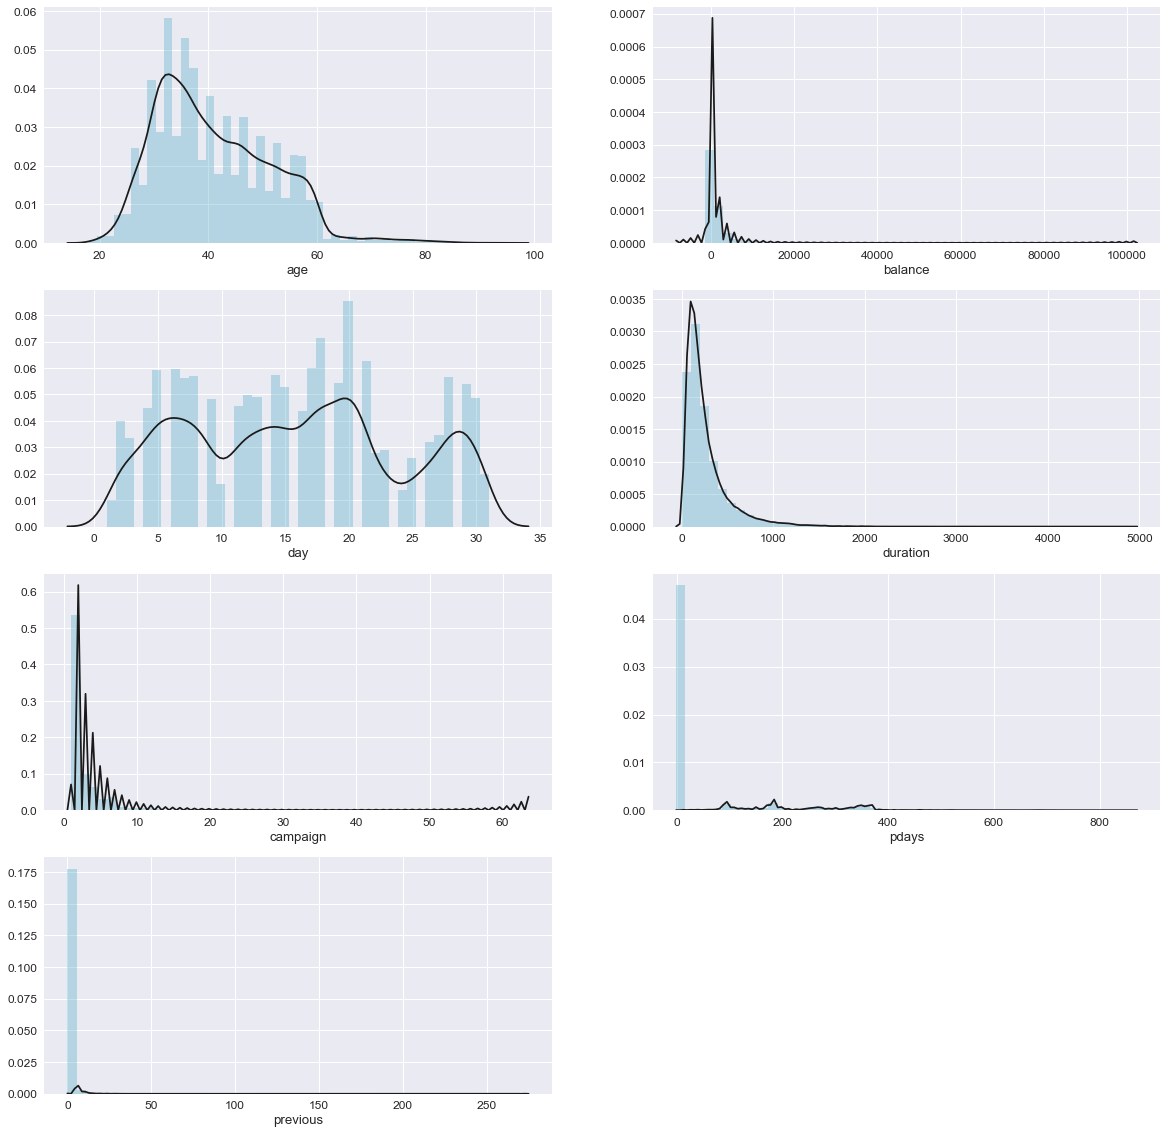

In [16]:
# Check for distribution skewness
plt.figure(figsize=(20,20))
index = 1
for col in numeric_cols:
    plt.subplot(round(len(numeric_cols) / 2), 2, index)
    sns.distplot(tds[col], kde_kws={"color": "k"}, hist_kws={"color": "c"})
    index += 1

In [17]:
Q1 = tds.quantile(0.25)
Q3 = tds.quantile(0.75)
IQR = Q3-Q1
print(IQR)
tds[(tds[numeric_cols] < (Q1 - 1.5 * IQR)) | (tds[numeric_cols] > (Q3 + 1.5 * IQR))].age

age           15.0
balance     1356.0
day           13.0
duration     216.0
campaign       2.0
pdays          0.0
previous       0.0
dtype: float64


0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
5         NaN
6         NaN
7         NaN
8         NaN
9         NaN
10        NaN
11        NaN
12        NaN
13        NaN
14        NaN
15        NaN
16        NaN
17        NaN
18        NaN
19        NaN
20        NaN
21        NaN
22        NaN
23        NaN
24        NaN
25        NaN
26        NaN
27        NaN
28        NaN
29        NaN
         ... 
45181     NaN
45182     NaN
45183     NaN
45184     NaN
45185     NaN
45186     NaN
45187     NaN
45188     NaN
45189     NaN
45190     NaN
45191    75.0
45192     NaN
45193     NaN
45194     NaN
45195     NaN
45196     NaN
45197     NaN
45198     NaN
45199     NaN
45200     NaN
45201     NaN
45202     NaN
45203     NaN
45204    73.0
45205     NaN
45206     NaN
45207    71.0
45208    72.0
45209     NaN
45210     NaN
Name: age, Length: 45211, dtype: float64

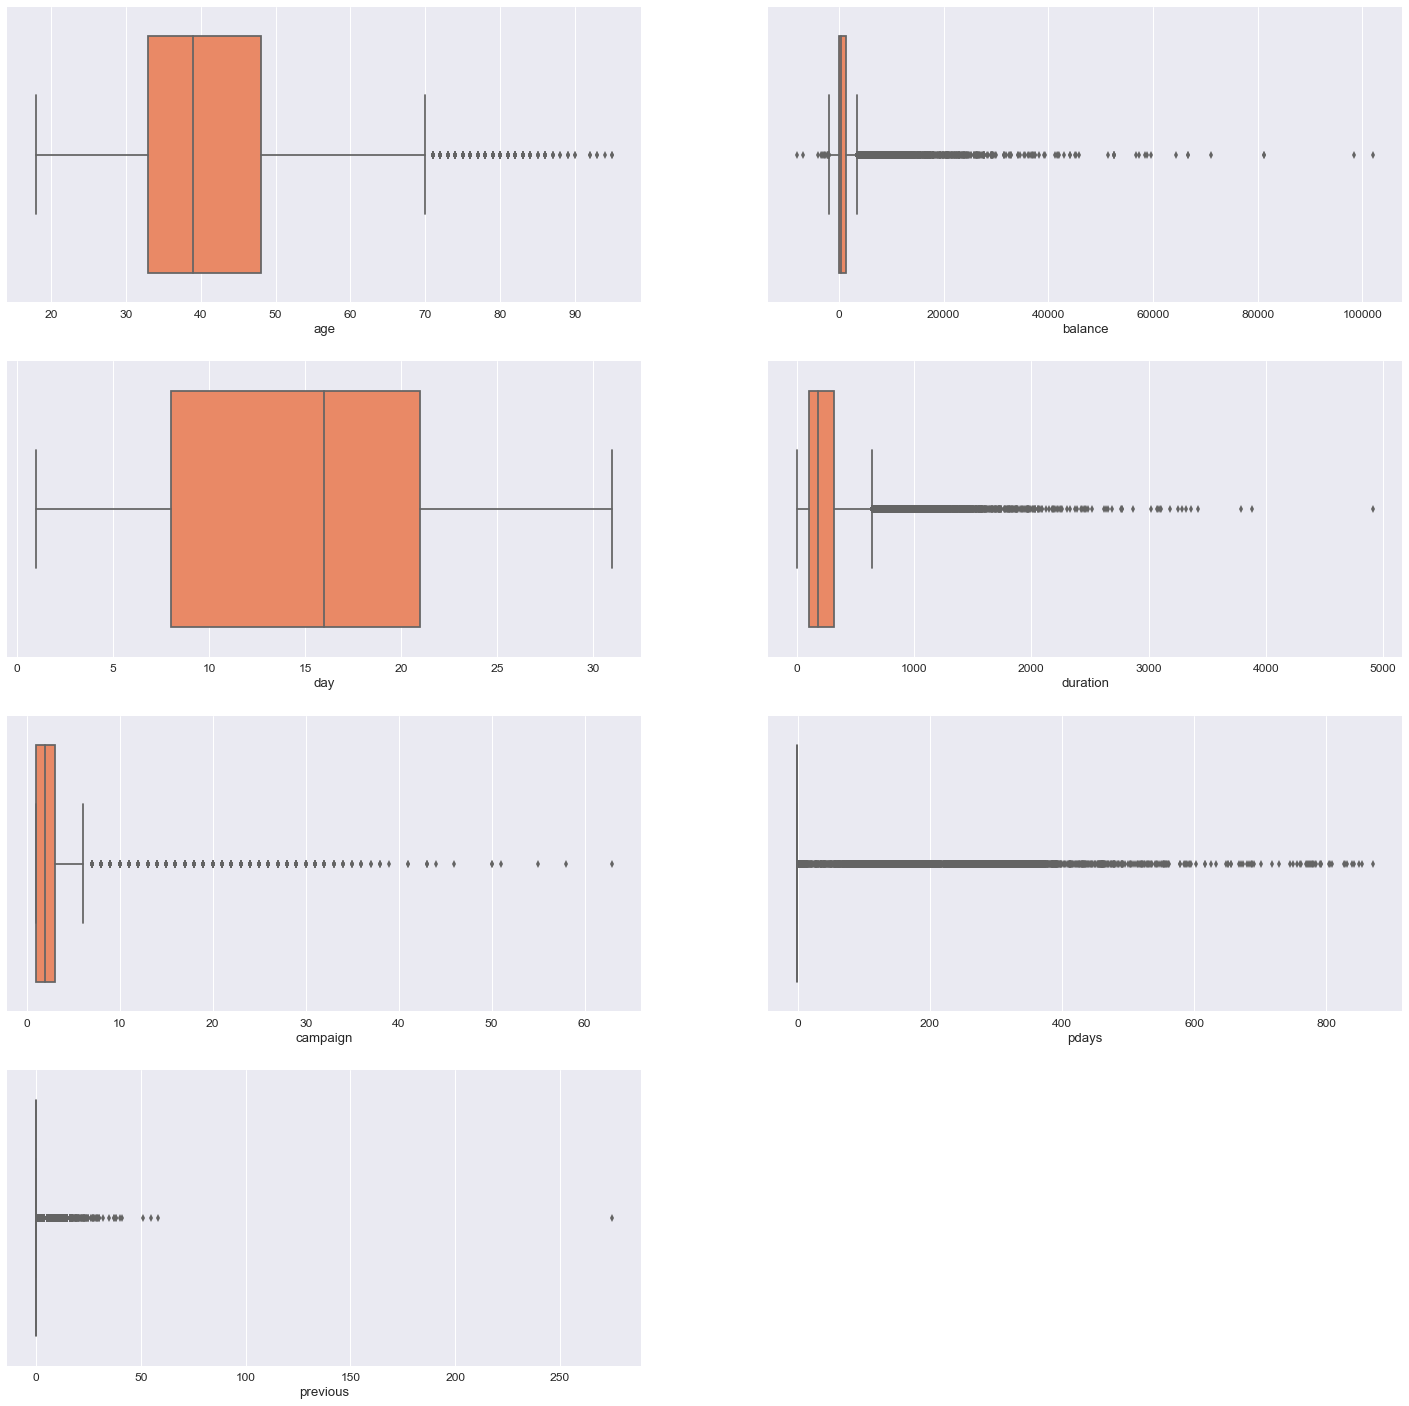

In [18]:
# Check the distribution Central Tendency
plt.figure(figsize=(25,25))
index = 1
for col in numeric_cols:
    plt.subplot(round(len(numeric_cols) / 2), 2, index)
    sns.boxplot(tds[col], color='coral')
    index += 1

In [19]:
# Check the count of OUTLIER observations in ech distribution
tds.age.quantile([0,0.25,0.5,0.75,1])

0.00    18.0
0.25    33.0
0.50    39.0
0.75    48.0
1.00    95.0
Name: age, dtype: float64

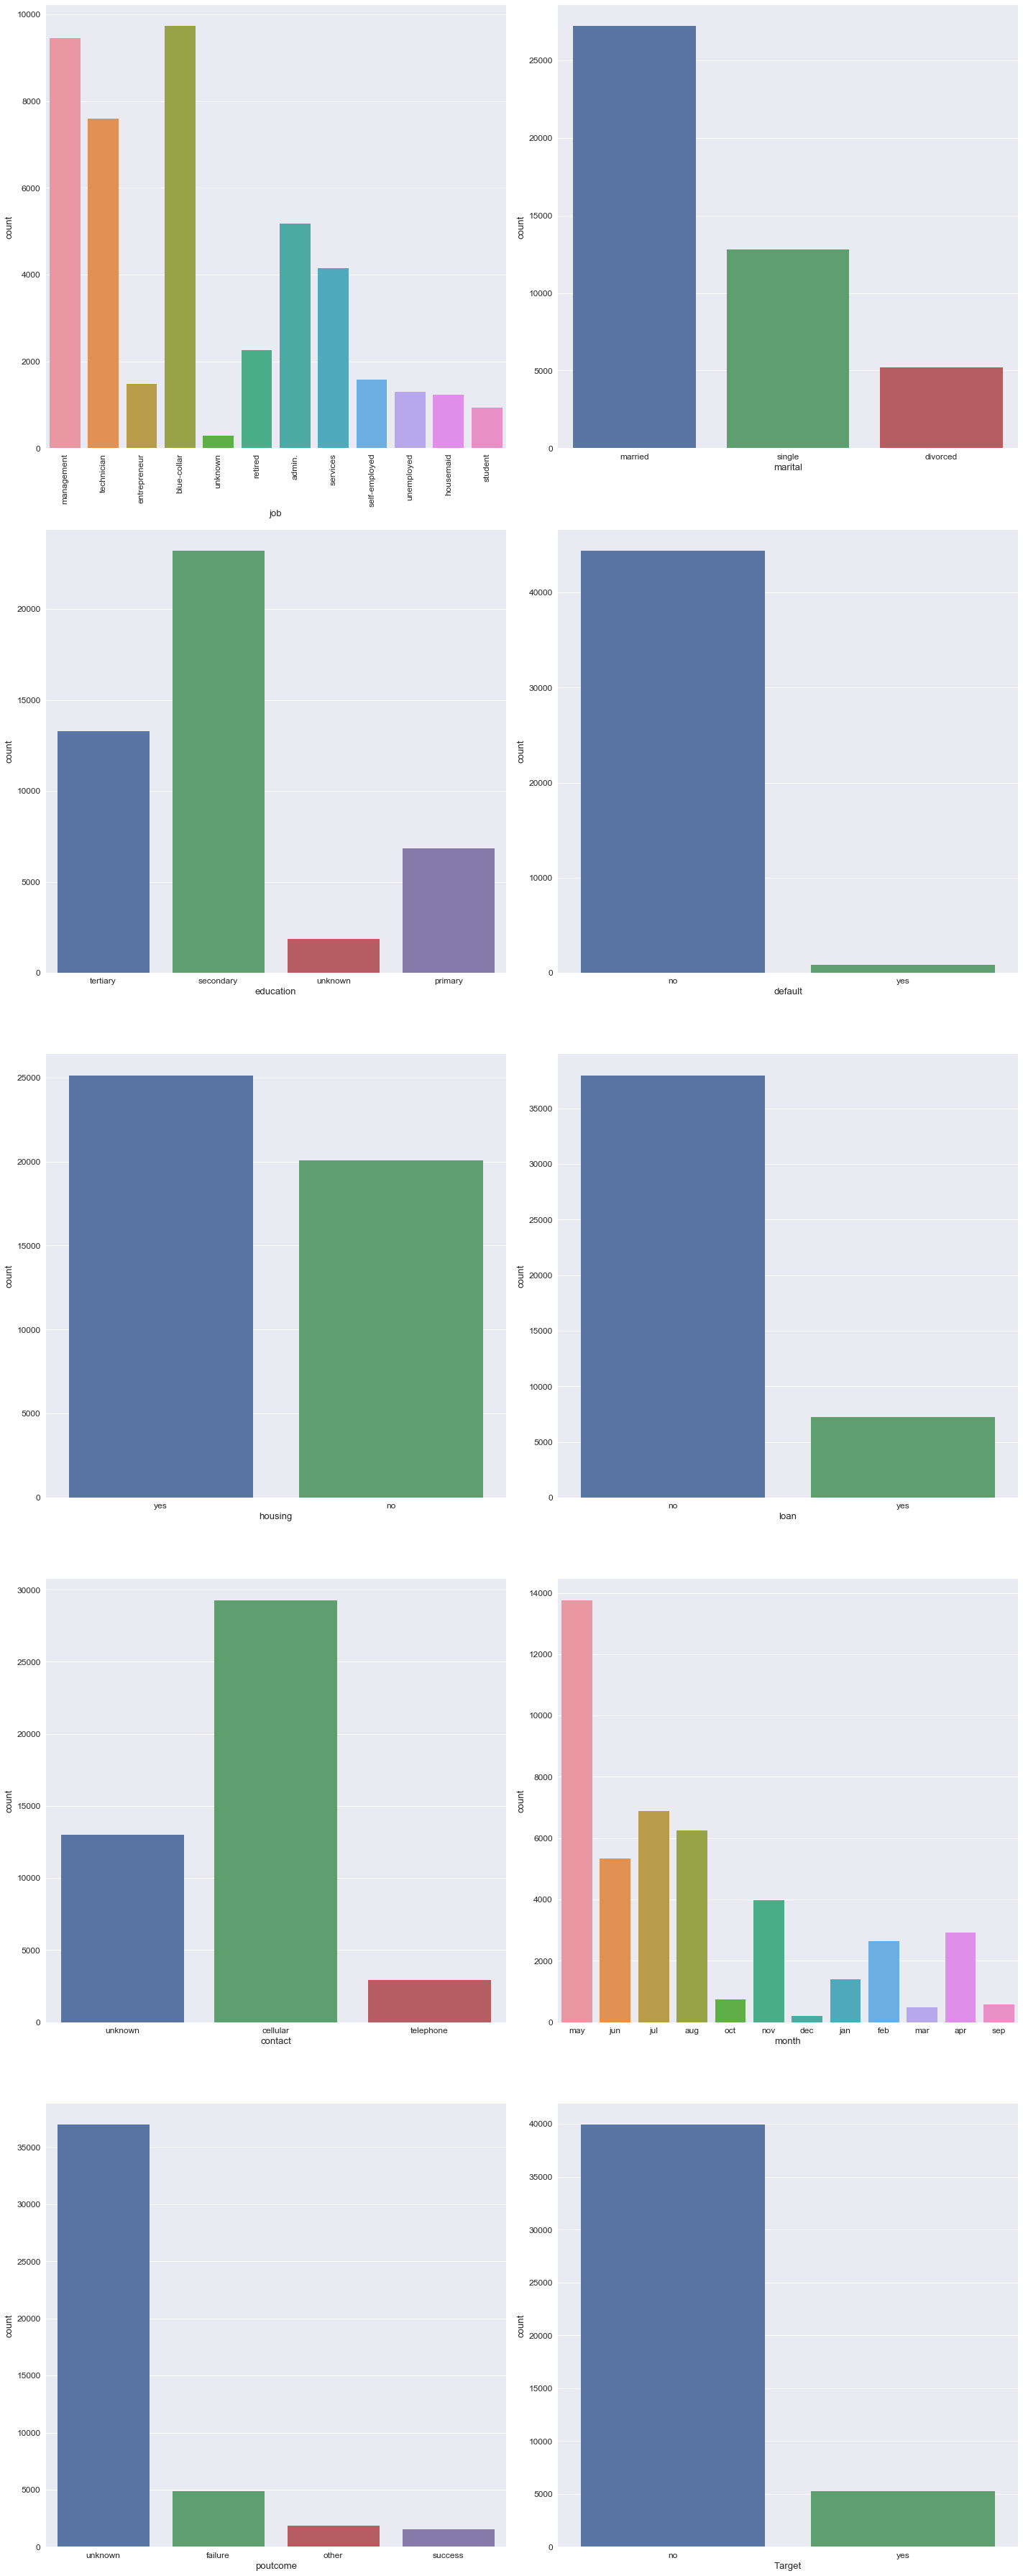

In [20]:
# Check the frequency inside the categorical features
plt.figure(figsize=(20,50))
index = 1
for col in categ_cols:
    plt.subplot(round(len(categ_cols) / 2), 2, index)
    sns.countplot(col, data=tds)
    if col == 'job':
        plt.xticks(rotation='vertical')
    index += 1
plt.tight_layout()

### Bivariate Analysis
Let's explore the relationship among the predictor variables and between the predictor variables and target column. We will be using the density curve plus histogram, boxplot and pairplots

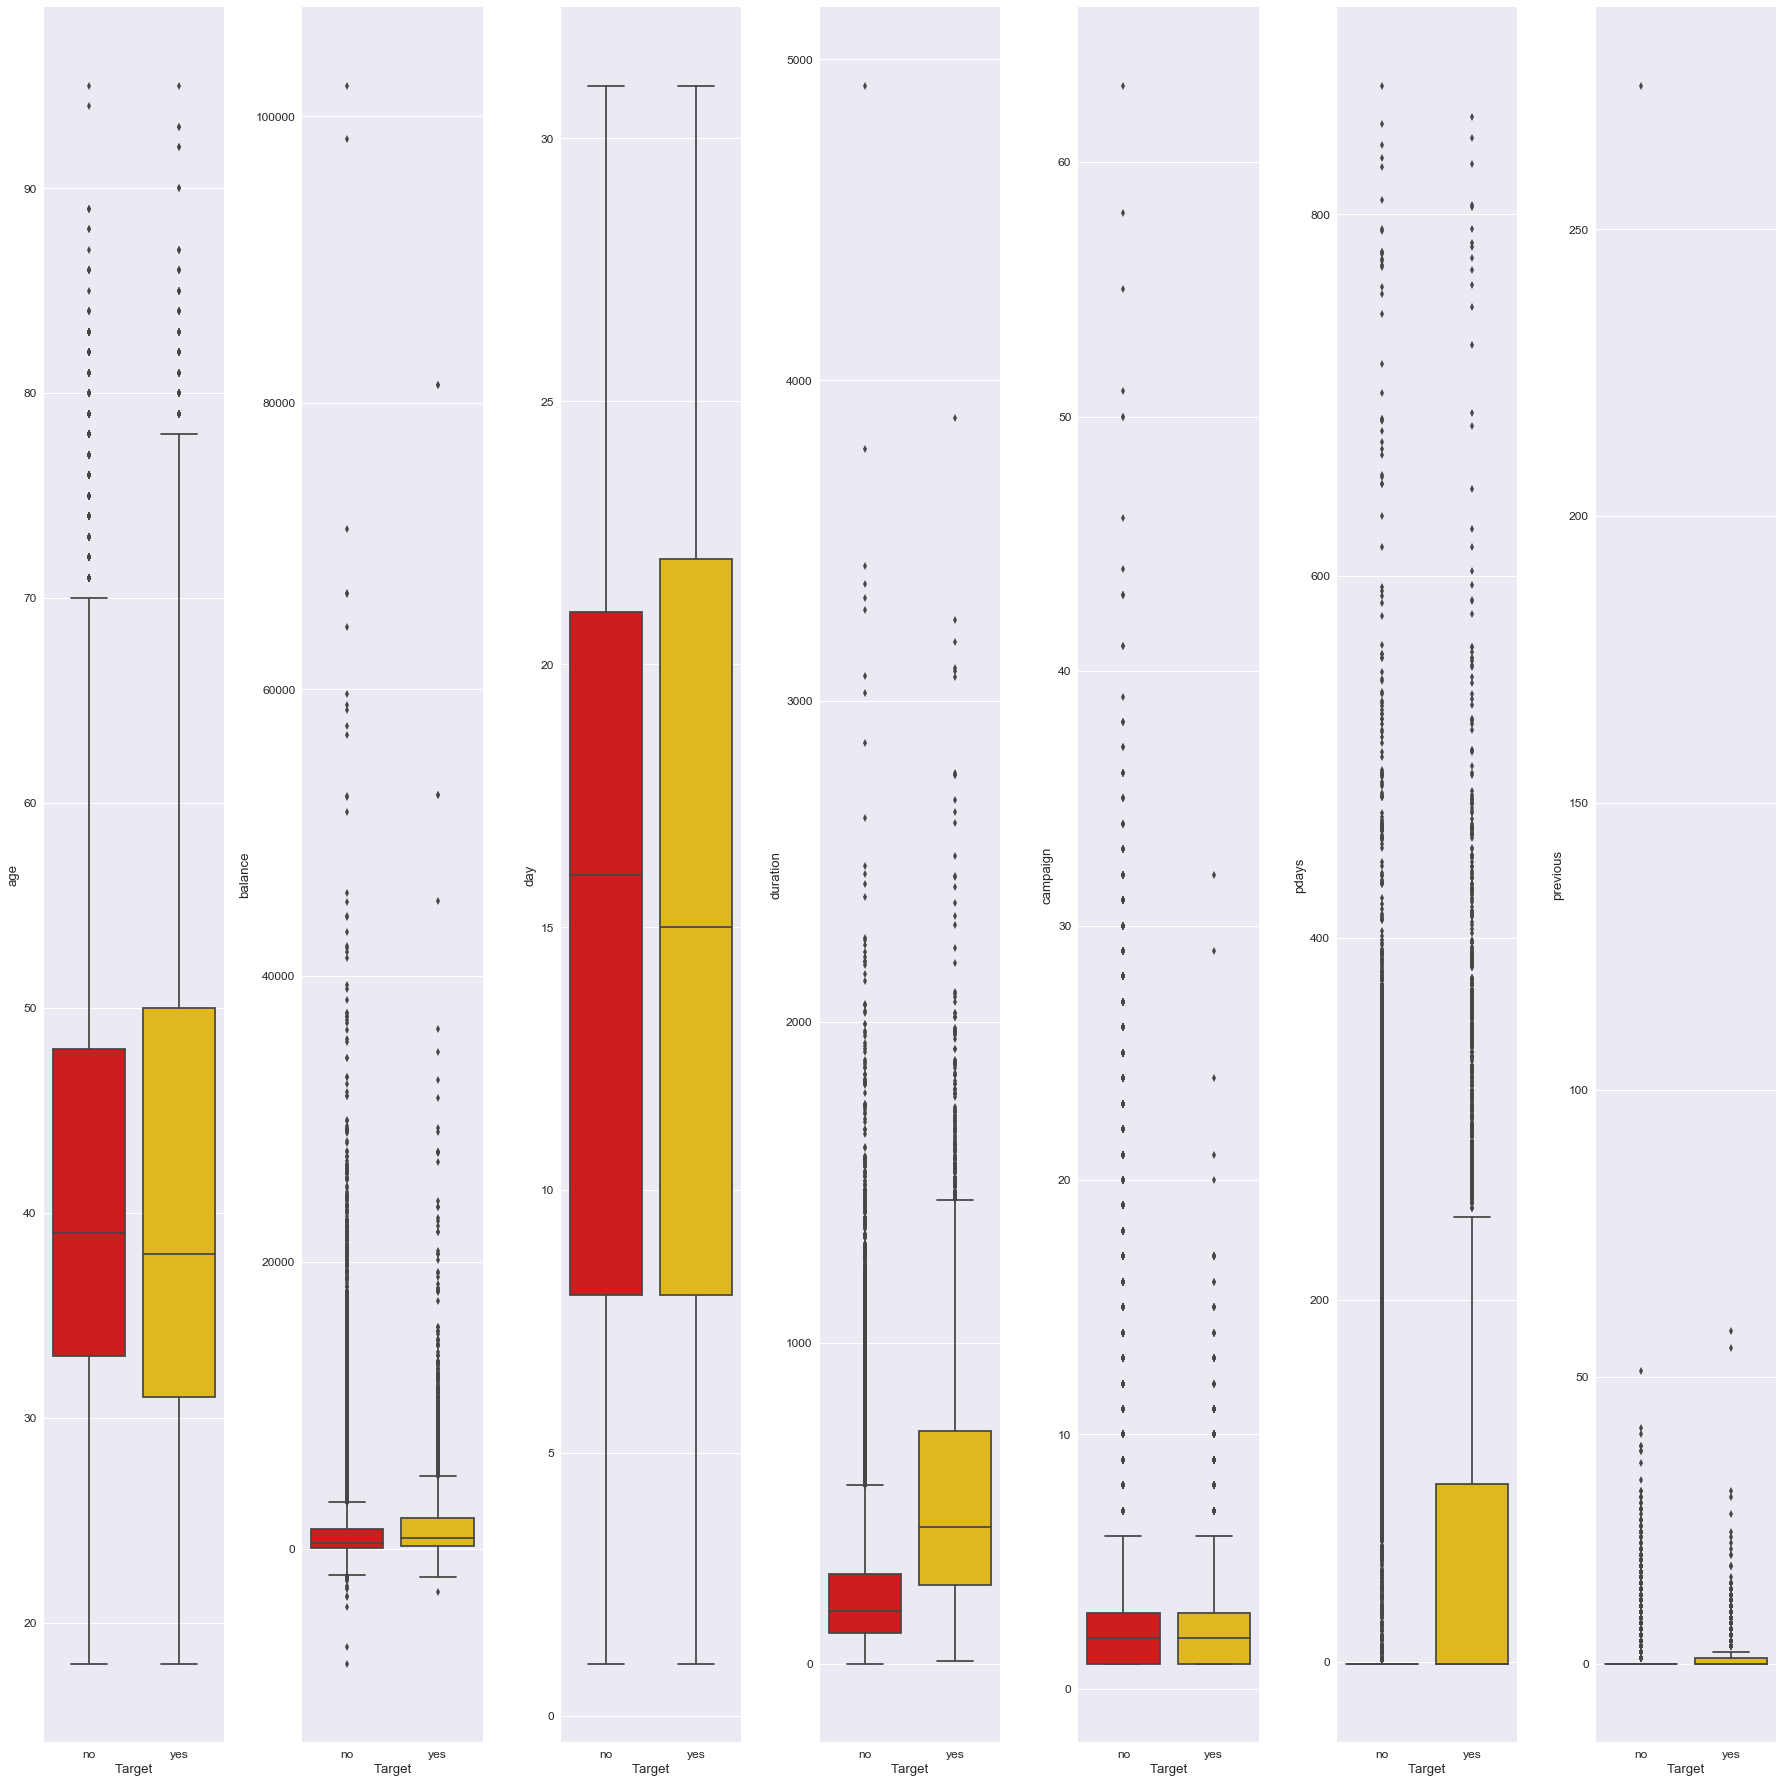

In [21]:
# Check the distribution Central Tendency for different Outcomes
plt.figure(figsize=(25,25))
index = 1
for col in numeric_cols:
    plt.subplot(1, len(numeric_cols), index)
    sns.boxplot(tds.Target, tds[col], palette='hot')
    index += 1
plt.tight_layout()

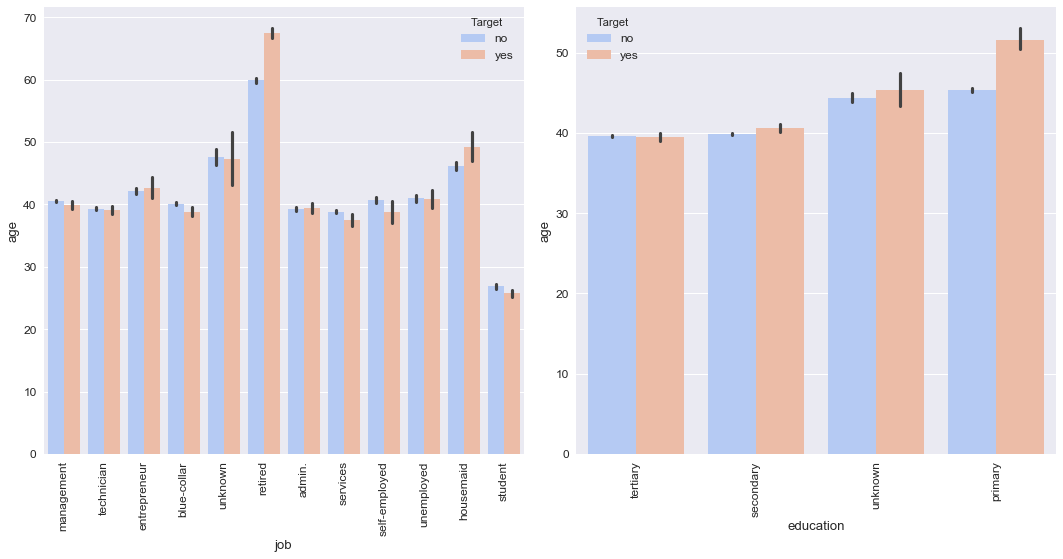

In [22]:
# Check the distribution Central Tendency for different Outcomes
plt.figure(figsize=(15,8))
index = 1
for col in ['job', 'education']:
    plt.subplot(1, 2, index)
    sns.barplot(tds[col], tds.age, tds.Target, palette='coolwarm')
    plt.xticks(rotation='vertical')
    index += 1
plt.tight_layout()

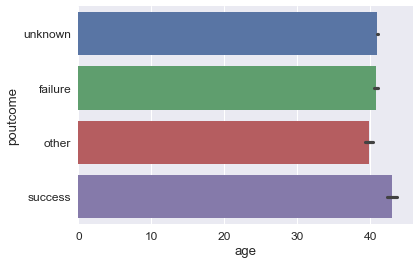

In [23]:
sns.barplot(tds.age, tds.poutcome)

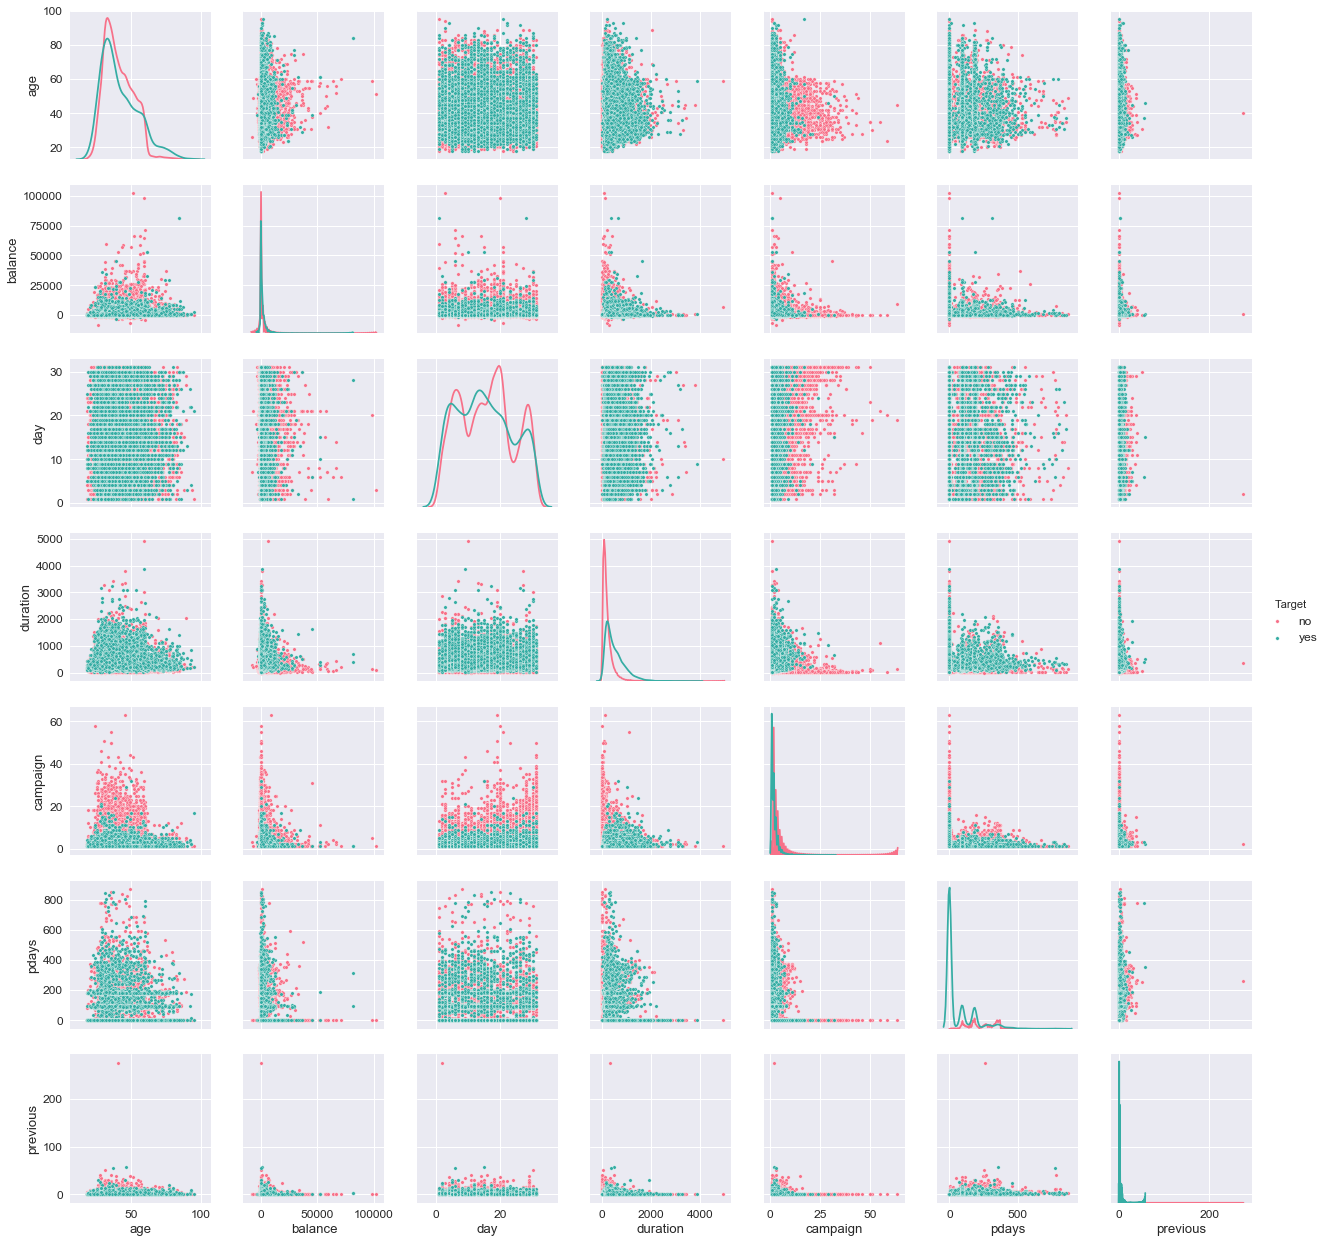

In [24]:
# Pairwise relationship of numerical features in each of the category of Target
sns.pairplot(tds, hue='Target', diag_kind='kde', palette='husl', markers='.')

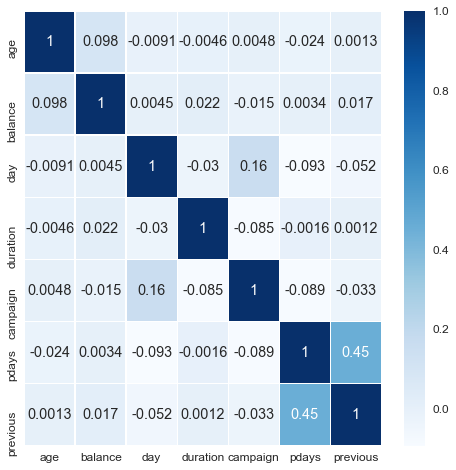

In [25]:
# Visualize the correlation matrix
plt.figure(figsize=(8,8))
sns.heatmap(tds.corr(), annot=True, cmap='Blues', linewidths=0.5)

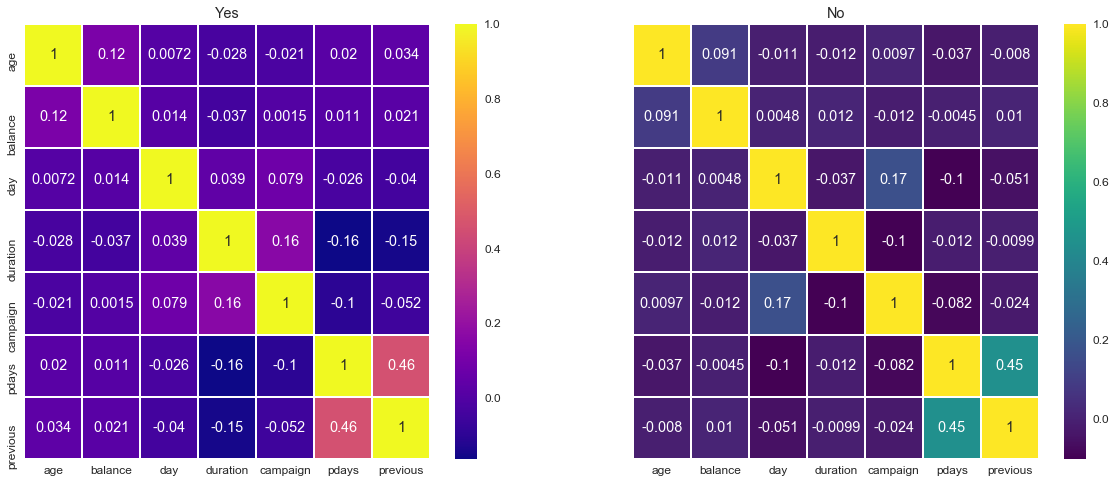

In [26]:
# Visualize the correlation matrix in each Outcomes category
f, axes = plt.subplots(ncols=2, sharey=True, figsize=(20,8))
axes[0].set_title('Yes')
sns.heatmap(tds[tds.Target == 'yes'].iloc[:,:-1].corr(), annot=True, cmap='plasma', linewidths=1, ax=axes[0])
axes[1].set_title('No')
sns.heatmap(tds[tds.Target == 'no'].iloc[:,:-1].corr(), annot=True, cmap='viridis', linewidths=1, ax=axes[1])

---
## Deliverable - 2 (Prepare the data for analytics)
1. Load the data into a data-frame. The data frame should have data and column description
Ensure the attribute types are correct. If not, take appropriate actions
3. Transform the data ie. scale/normalize if required
4. Create the training set and test set in ratio of 70:30

### Feature Engineering
Feature Engineering is the process of cleaning and refining the crude data and transform to some format which machines can understand. The efforts main have two goals
- Preparing the proper input dataset, compatible with the machine learning algorithm requirements.
- Improving the performance of machine learning models

Most of the Machine Learning algorithms are only good at numbers. So, in order to feed them the categorical data that we have, we need to convert them into numerical values using any of the Text Encoder
• One Hot Encoding
• Label Encoding

#### LabelEncode the categorical variables
LabelEncoder() encodes labels with a value between 0 and (n-1) where n is the number of distinct labels in a column. If a label repeats, it assigns the same value to it as assigned earlier.

In [27]:
# Convert all the categorical columns to numerical
tds=pd.read_csv('bank-full.csv')
le = LabelEncoder()
for col in categ_cols:
    tds[col] = le.fit_transform(tds[col])
    print(f'{col}:', dict(zip(le.classes_, range(len(le.classes_)))))
    
print()
tds.info()

job: {'admin.': 0, 'blue-collar': 1, 'entrepreneur': 2, 'housemaid': 3, 'management': 4, 'retired': 5, 'self-employed': 6, 'services': 7, 'student': 8, 'technician': 9, 'unemployed': 10, 'unknown': 11}
marital: {'divorced': 0, 'married': 1, 'single': 2}
education: {'primary': 0, 'secondary': 1, 'tertiary': 2, 'unknown': 3}
default: {'no': 0, 'yes': 1}
housing: {'no': 0, 'yes': 1}
loan: {'no': 0, 'yes': 1}
contact: {'cellular': 0, 'telephone': 1, 'unknown': 2}
month: {'apr': 0, 'aug': 1, 'dec': 2, 'feb': 3, 'jan': 4, 'jul': 5, 'jun': 6, 'mar': 7, 'may': 8, 'nov': 9, 'oct': 10, 'sep': 11}
poutcome: {'failure': 0, 'other': 1, 'success': 2, 'unknown': 3}
Target: {'no': 0, 'yes': 1}

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null int64
marital      45211 non-null int64
education    45211 non-null int64
default      45211 non-null int64
balance      45211 non-null int64

#### Feature Scaling
Algorithms that exploit distances or similarities between data samples, such as k-NN and SVM, are sensitive to scale of the features. Other graphical-model based classifiers are invariant to feature scaling, but still it might be a good idea to rescale/standartize your data.

StandardScaler() will normalize the features so that each column/feature/variable will have mean = 0 and standard deviation = 1. 

In [28]:
X = tds.drop('Target', axis=1)
y = tds.Target
sc = StandardScaler()
scaled_data = sc.fit_transform(X)
scaled_data = pd.DataFrame(scaled_data, columns=X.columns)
scaled_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,1.606965,-0.103820,-0.275762,1.036362,-0.13549,0.256419,0.893915,-0.436803,1.514306,-1.298476,0.823773,0.011016,-0.569351,-0.411453,-0.25194,0.444898
1,0.288529,1.424008,1.368372,-0.300556,-0.13549,-0.437895,0.893915,-0.436803,1.514306,-1.298476,0.823773,-0.416127,-0.569351,-0.411453,-0.25194,0.444898
2,-0.747384,-0.714951,-0.275762,-0.300556,-0.13549,-0.446762,0.893915,2.289359,1.514306,-1.298476,0.823773,-0.707361,-0.569351,-0.411453,-0.25194,0.444898
3,0.571051,-1.020516,-0.275762,2.373280,-0.13549,0.047205,0.893915,-0.436803,1.514306,-1.298476,0.823773,-0.645231,-0.569351,-0.411453,-0.25194,0.444898
4,-0.747384,2.035139,1.368372,2.373280,-0.13549,-0.447091,-1.118674,-0.436803,1.514306,-1.298476,0.823773,-0.233620,-0.569351,-0.411453,-0.25194,0.444898


#### Sample spliting
Divide the dataset into train-test in a ratio of 70:30 for training set and test set

In [29]:
X_train, X_test, y_train, y_test = train_test_split(scaled_data, y, test_size=0.3, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((31647, 16), (13564, 16), (31647,), (13564,))